# Create the database for trainning

In [1]:
# Load packages

from netCDF4 import Dataset
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import sys
import netCDF4 as nc4

sys.path.append("/home2/datahome/tpicard/python/Python_Modules_p3_pyticles/")

from Modules import *
from Modules_gula import *

# Find filtered inputs

In [2]:
#Take all the inputs (ssh, temperature, ect...) for 101 days of simulation. Inputs are centered in respect with the #patch associated.
#Return inputs for every sample during this period 
#400x400 : spatial resolution
#3 : number of vertical layer
#6 : number of time step for 101 days period
#36 : number of particules patches 

[ic,jc] = np.load('/home2/datahome/tpicard/Pyticles/Inputs/ic_jc.npy')

ic_all_list = ic - np.linspace(1521,1611,6).astype(int) ### WARNING BIAS OF 1km ###
jc_all_list = jc - np.linspace(570,660,6).astype(int)
    
def input_spacial_filter(ncfile,ic_all_list,jc_all_list):
    
    nc = nc4.Dataset('/home2/datawork/tpicard/Pyticles/INPUTS/{0}'.format(ncfile),'r')
    
    temperature = np.asfortranarray(nc.variables['temperature'])
    vrt = np.asfortranarray(nc.variables['vorticity'])
    u = np.asfortranarray(nc.variables['u'])
    v = np.asfortranarray(nc.variables['v'])
    ssh = np.asfortranarray(nc.variables['ssh'])
    
    nc.close()

    temperature_filtrer = np.zeros((400,400,3,6,36))
    vrt_filtrer = np.zeros((400,400,3,6,36))
    u_filtrer = np.zeros((400,400,3,6,36))
    v_filtrer = np.zeros((400,400,3,6,36))
    ssh_filtrer = np.zeros((400,400,6,36))
    i = 0
    
    for d_ic in ic_all_list:
        for d_jc in jc_all_list:
            temperature_filtrer[:,:,:,:,i] = temperature[60+d_ic:-60+d_ic,60+d_jc:-60+d_jc,:,:]
            vrt_filtrer[:,:,:,:,i] = vrt[60+d_ic:-60+d_ic,60+d_jc:-60+d_jc,:,:]
            u_filtrer[:,:,:,:,i] = u[59+d_ic:-60+d_ic,60+d_jc:-60+d_jc,:,:]
            v_filtrer[:,:,:,:,i] = v[60+d_ic:-60+d_ic,60+d_jc:-59+d_jc,:,:]
            ssh_filtrer[:,:,:,i] = ssh[60+d_ic:-60+d_ic,60+d_jc:-60+d_jc,:]
            i = i+1
    return(temperature_filtrer,vrt_filtrer,u_filtrer,v_filtrer,ssh_filtrer)
        

# Find outputs pdf

In [3]:
# Take all pdf for a 101 days period

def output_spacial_filterd(datetime):
    
    ncfile = 'output_date_{0:06}.nc'.format(datetime)
    nc = nc4.Dataset('/home2/datawork/tpicard/Pyticles/OUTPUTS/PDF/{0}'.format(ncfile),'r')

    pdf = np.asfortranarray(nc.variables['pdf'])
    nc.close()

    return(pdf)
        

# Build the trainning database

In [6]:
# The database will be composed by 64 nc files that each crroespond to a period of 101 days of simulation
# Each nc file containt 108 sample 
# A total of 6912 samples 
# First year souldn't be used for the moment because this is a spin-up year for simulation.


# Choose the folder
folder_input = '/home2/datawork/tpicard/Pyticles/INPUTS/'


nb_sample = 108 # Number of sample for each
zdim = 52 # Number of images used in inputs (12 temperature, 12 vrt, 12 u, 12 v and 4 ssh = 52 images)


for tpas in range(0,65,1):

    date = 101*tpas 
    
    ncfile = 'inputs_date_{0:06}.nc.'.format(date)
    print('date = {0}'.format(date))
    
    temperature,vrt,u,v,ssh = input_spacial_filter(ncfile,ic_all_list,jc_all_list)
    pdf = output_spacial_filterd(date)

    inputs = np.zeros((nb_sample,400,400,zdim))
    i = 0

    nc = nc4.Dataset('/home2/datawork/tpicard/Pyticles/CNN_DATA/trainning_database_{0:06}.nc'.format(date),'w')

    #Dimensions used for inputs
    nc.createDimension('xdim', 400)
    nc.createDimension('ydim', 400)
    nc.createDimension('zdim', 52)

    #Dimensions used for inputs
    nc.createDimension('xdim_pdf', 80)
    nc.createDimension('ydim_pdf', 80)
    nc.createDimension('zdim_pdf', 1)

    #Number of samples used for both
    nc.createDimension('nb_sample', nb_sample)

    #Variables
    nc.createVariable('inputs', 'f4', ('nb_sample','xdim', 'ydim','zdim'))
    nc.createVariable('outputs', 'f4', ('nb_sample','xdim_pdf', 'ydim_pdf','zdim_pdf'))

    
    for dt in range(0,3):
        for dh in range(0,36):
        
            temp_out = temperature[:,:,:,dt:dt+4,dh]
            vrt_out = vrt[:,:,:,dt:dt+4,dh]
            u_out = u[:,:,:,dt:dt+4,dh]
            v_out = v[:,:,:,dt:dt+4,dh]
            input_tempo = np.concatenate((temp_out, vrt_out,u_out,v_out), axis=2)
            input_tempo = input_tempo.reshape(400,400,48)
            ssh_out = ssh[:,:,dt:dt+4,dh]
            inputs_out = np.concatenate((input_tempo,ssh_out), axis=2)
            inputs[i,:,:,:] = inputs_out
            pdf_out = pdf[dh,dt,:,:,:]
            pdf_out = np.transpose(pdf_out, axes=[1, 2, 0])
            nc.variables['inputs'][i,:,:,:] = inputs_out
            nc.variables['outputs'][i,:,:,:] = pdf_out
            i = i+1
        
    #nc_data = nc4.Dataset('/home2/datawork/tpicard/Pyticles/CNN_DATA/trainning_database.nc','w')        
    #nc_data.variables['input'][tpas*108:(tpas+1)*108,:,:,:] = inputs[:,:,:,:]
    nc.close()


date = 0
date = 101
date = 202
date = 303
date = 404
date = 505
date = 606
date = 707
date = 808
date = 909
date = 1010
date = 1111
date = 1212
date = 1313
date = 1414
date = 1515
date = 1616
date = 1919
date = 2020
date = 2121
date = 2222
date = 2323
date = 2424
date = 2525
date = 2626
date = 2727
date = 2828
date = 2929
date = 3030
date = 3131
date = 3232
date = 3333
date = 3434
date = 3535
date = 3636
date = 3737
date = 3838
date = 3939
date = 4040
date = 4141
date = 4242
date = 4343
date = 4444
date = 4545
date = 4646
date = 4747
date = 4848
date = 4949
date = 5050
date = 5151
date = 5252
date = 5353
date = 5454
date = 5555
date = 5656
date = 5757
date = 5858
date = 5959
date = 6060
date = 6161
date = 6262
date = 6363
date = 6464


# TEST THE DATABASE

In [8]:
#Load one of the nc file 

datetime=101*30
nc = nc4.Dataset('/home2/datawork/tpicard/Pyticles/CNN_DATA/trainning_database_{0:06}.nc'.format(datetime),'r')
inputs = np.asfortranarray(nc.variables['inputs'])
outputs = np.asfortranarray(nc.variables['outputs'])
nc.close()

In [5]:
nb = 35 # Which sample, choose between 0 and 108

<ipython-input-9-3b70d3da6f01>:8: UserWarning: Log scale: values of z <= 0 have been masked
  ctf = plt.contourf(0.5*(xband[:-1]+xband[1:]), 0.5*(yband[:-1]+yband[1:]), outputs[nb,:,:,0].T,  levels, norm=norm, cmap=cmap, extend='both')


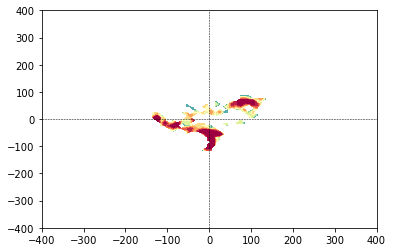

In [9]:
### Plot pdf ###

#xband, yband = np.linspace(-800,800,160), np.linspace(-800,800,160)
xband, yband = np.linspace(-400,400,81), np.linspace(-400,400,81)

plt.figure()
cmap = 'Spectral_r'
levels=np.logspace(-5, -4, 10)
norm= colors.LogNorm(vmin=1e-5, vmax=1e-4)
ctf = plt.contourf(0.5*(xband[:-1]+xband[1:]), 0.5*(yband[:-1]+yband[1:]), outputs[nb,:,:,0].T,  levels, norm=norm, cmap=cmap, extend='both')
#cb.set_ticks([1e-6, 1e-5, 1e-4])
#cb.ax.tick_params(labelsize='large')
plt.xlim([-400,400])
plt.ylim([-400,400])

plt.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
plt.axhline(y=0,color='black',linestyle='--',linewidth=0.5)

# Visual test

<ipython-input-10-0f04300ae41b>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y,inputs[nb,:,:,10])


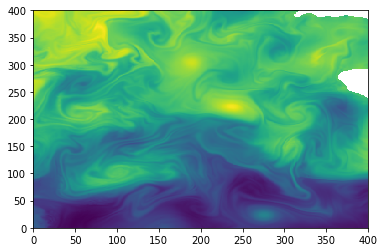

In [10]:
### Plot one of the 52 input images ###

x = np.linspace(0,400,400)
y = np.linspace(0,400,400)
plt.pcolormesh(x,y,inputs[nb,:,:,10])